starting to fit...
loopnum: 2000


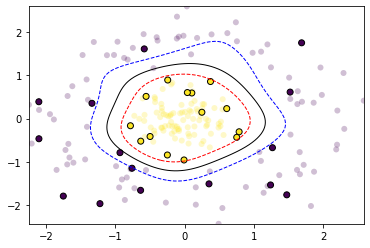

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler


class SMOStruct:
    def __init__(self, X, y, C, kernel, alphas, b, errors, user_linear_optim):
        self.X = X  # 训练样本
        self.y = y  # 类别 label
        self.C = C  # 正则化常量(惩罚系数)
        self.kernel = kernel  # 核函数，实现了两个核函数，线性和高斯（RBF）
        self.alphas = alphas  # 拉格朗日乘子，与样本一一对应
        self.b = b  # bias  标量
        self.errors = errors  # 用于存储alpha的实际值与预测值得差值,即E
        self.m, self.n = np.shape(self.X)  # m=训练样本个数；n=特征数
        self.user_linear_optim = user_linear_optim  # bool，判断模型是否使用线性核函数
        self.w = np.zeros(self.n)  # 初始化权重w的值，用于线性核函数


def linear_kernel(x, y, b=1):
    # 线性核函数
    result = x @ y.T + b
    return result


def gaussian_kernel(x, y, sigma=1):
    # 高斯核函数,式（2.7）
    # sigma=式（2.7）的标准差
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        result = np.exp(-(np.linalg.norm(x - y, 2)) ** 2 / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        result = np.exp(-(np.linalg.norm(x - y, 2, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        result = np.exp(-(np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))
    return result


# 判别函数一，用于单一样本
def decision_function_output(model, i):
    if model.user_linear_optim:
        return float(model.w.T @ model.X[i]) - model.b
    else:
        return np.sum(
            [model.alphas[j] * model.y[j] * model.kernel(model.X[j], model.X[i]) for j in range(model.m)]) - model.b


# 判别函数二：一次求多个样本
def decision_function(alphas, target, kernel, X_train, x_test, b):

    result = (alphas * target) @ kernel(X_train, x_test) - b
    return result


def plot_decision_boundary(model, ax, resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
    # 绘出分割平面及支持平面，等高线的方法

    # Generate coordinate grid of shape [resolution x resolution]
    # and evalute the model over the entire space
    xrange = np.linspace(model.X[:, 0].min(), model.X[:, 0].max(), resolution)
    yrange = np.linspace(model.X[:, 1].min(), model.X[:, 1].max(), resolution)
    grid = [[decision_function(model.alphas, model.y, model.kernel, model.X,
                               np.array([xr, yr]), model.b) for xr in xrange] for yr in yrange]

    grid = np.array(grid).reshape(len(xrange), len(yrange))

    # Plot decision contours using grid and
    # make a scatter plot of training data
    ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
               linestyles=('--', '-', '--'), colors=colors)
    ax.scatter(model.X[:, 0], model.X[:, 1],
               c=model.y, cmap=plt.cm.viridis, lw=0, alpha=0.25)

    # Plot support vectors (non-zero alphas)
    # as circled points (linewidth >0)
    mask = np.round(model.alphas, decimals=2) != 0.0
    ax.scatter(model.X[mask, 0], model.X[mask, 1],
               c=model.y[mask], cmap=plt.cm.viridis, lw=1, edgecolors='k')

    return grid, ax


# 选择了alpha2, alpha1后开始优化，然后迭代， “第二层循环，内循环”
# 主要的迭代由此函数完成
def take_step(i1, i2, model):
    # skip if chosen alphas are the same
    if i1 == i2:
        return 0, model
    # 确定的子问题的变量
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    # 标签
    y1 = model.y[i1]
    y2 = model.y[i2]
    # 差值E，若优化，要更新
    E1 = get_error(model, i1)
    E2 = get_error(model, i2)
    s = y1 * y2

    # 计算alpha的边界，L, H。对应式（3.5）
    if (y1 != y2):
        # y1,y2 异号
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        # y1,y2 同号
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model
    # 计算核函数值；k11=K11=K(x1,x2),计算方式却决于选择的核函数
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    # 计算 eta，含义与实验报告相同，式（3.4）
    eta = k11 + k22 - 2 * k12
    # 计算没clip的a2
    a2 = alph2 + y2 * (E1 - E2) / eta
    # clip a2,得到最终的更新值new a2,式（3.3）
    if L < a2 < H:
        a2 = a2
    elif (a2 <= L):
        a2 = L
    elif (a2 >= H):
        a2 = H

    # 当new a2 接近C或0是，就认为等于C或0
    if a2 < 1e-3:
        a2 = 0.0
    elif a2 > (model.C - 1e-3):
        a2 = model.C
    # 超过容差epsilon(eps)仍不能优化时，跳过
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model

    # 根据new a2 ，更新a1 式（3.2）
    a1 = alph1 + s * (alph2 - a2)
    # 更新 bias b的值 式（3.6）
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b
    # 根据更新规则，选择b1还是b2作为新值
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    else:
        b_new = (b1 + b2) * 0.5
    # 更新bias
    model.b = b_new

    # 当所训练模型为线性核函数时
    if model.user_linear_optim:
        model.w = model.w + y1 * (a1 - alph1) * model.X[i1] + y2 * (a2 - alph2) * model.X[i2]
    # 更新model中的alphas
    model.alphas[i1] = a1
    model.alphas[i2] = a2

    # 更新差值矩阵的对应值，同时更新差值矩阵其它值
    model.errors[i1] = 0
    model.errors[i2] = 0
    # 更新差值 式（3.7）
    for i in range(model.m):
        if 0 < model.alphas[i] < model.C:
            model.errors[i] += y1 * (a1 - alph1) * model.kernel(model.X[i1], model.X[i]) + \
                               y2 * (a2 - alph2) * model.kernel(model.X[i2], model.X[i]) + \
                               model.b - b_new
    return 1, model


def get_error(model, i1):
    if 0 < model.alphas[i1] < model.C:
        return model.errors[i1]
    else:
        return decision_function_output(model, i1) - model.y[i1]


def examine_example(i2, model):
    # 取索引对应的值
    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = get_error(model, i2)
    r2 = E2 * y2  # 带符号差值

    # 确定 alpha1, 也就是old a1，并送到take_step去执行优化
    # 下面条件之一满足，进入if开始找第二个alpha，送到take_step进行优化
    # 对应式（3.8），如if为真，则说明KKT条件已满足，退出找其他样本
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):
        # 若0到C之间的a的数量大于1，
        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            # 选择Ei矩阵中差值最大的先进行优化
            # 要想|E1-E2|最大，只需要在E2为正时，选择最小的Ei作为E1
            # 在E2为负时选择最大的Ei作为E1
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            # 若有优化，则返回的是更新后的model
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
        # 若没能成功优化，则在0到C之间再随机选取a
        # 循环所有非0 非C alphas值进行优化，随机选择起始点
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model

        # a2确定的情况下，如何选择a1? 循环所有(m-1) alphas, 随机选择起始点
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)

            if step_result:
                return 1, model
    return 0, model


def fit(model):
    numChanged = 0  # 记录每次迭代中优化成功的次数
    examineAll = 1  # flag指示器，外循环结束（优化一轮）则置0
    # 计数器，记录优化时的循环次数
    loopnum = 0  # 迭代次数计数

    # 当numChanged = 0 and examineAll = 0时 循环退出
    # 实际是顺序地执行完所有的样本，也就是第二个if中的循环，
    # 如果else中的循环没有可优化的alpha，目标函数收敛了： 在容差之内，并且满足KKT条件则循环退出
    # 先寻找a2，再在examine_example里找a1,并在函数内部调用take_step执行优化
    while (numChanged > 0) or (examineAll):  # 如果一次迭代中没有任何一个优化，则结束
        numChanged = 0
        if loopnum >= 2000:  # 迭代上限
            break
        loopnum = loopnum + 1
        if examineAll:  # examineAll=1表示执行一轮优化
            # 按索引顺序选择a2，送给examine_example选择a1，并执行优化。总共会选择m(m-1)次a1
            for i in range(model.alphas.shape[0]):
                # 根据当前的a2,送到examine_example里找a1,
                # 如果完成一次优化，返回优化的model，否则原样返回
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
        else:
            # 选择在边界的点（乘子非0，非C），加快迭代
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
        # 切换flag指示器 examineAll
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1
    print("loopnum:", loopnum,)
    return model


# -------分割线-线性分类问题---------
'''
# 线性分类问题
# 生成测试数据，训练样本
# n_samples=样本数
# centers=样本类别数
# n_features=特征数
# random_state=随机种子
X_train, y = make_blobs(n_samples=200, centers=2, n_features=2, random_state=0)
# 根据所有样本的均值和方差对样本做标准差标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
y[y == 0] = -1  # y值属于{+1，-1}

# 参数设置
C = 1.0    # 惩罚系数
m = len(X_train_scaled)  # 样本数
initial_alphas = np.zeros(m)    # 拉格朗日乘子alphas
initial_b = 0.0     # bias,截距

# 设置容差
tol = 0.01  # 对应Ei
eps = 0.01  # 对应拉格朗日乘子

# 创建模型结构
model = SMOStruct(X_train_scaled, y, C, linear_kernel, initial_alphas, initial_b, np.zeros(m), user_linear_optim=True)
# print("model created ...")
# 初始化E，E是预测值和真实值之差
initial_error = decision_function(model.alphas, model.y, model.kernel, model.X, model.X, model.b) - model.y
# 更新E
model.errors = initial_error
# 固定随机数种子
np.random.seed(0)
'''
# --------分割线-非线性分类问题--------

# 非线性分类问题

# 生成测试数据，训练样本
# n_samples=样本数
# noise=高斯噪声
# random_state=随机数种子

#X_train, y = make_moons(n_samples=200, noise=0.1,random_state=1)
X_train, y = make_circles(n_samples=200, noise=0.2,
                         factor=0.1,
                         random_state=1)



# 根据所有样本的均值和方差对样本做标准差标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y)
y[y == 0] = -1  # y值属于{+1，-1}
# 设置参数和赋初值
C = 1.0  # 惩罚系数
m = len(X_train_scaled)  # 样本数
initial_alphas = np.zeros(m)    # 拉格朗日乘子alphas赋0
initial_b = 0.0  # bias，截距
# 容差
tol = 0.01  # 对应E
eps = 0.01  # epsilon,对应alphas，
# 创建SMOStruct对象 lambda x, y: gaussian_kernel(x, y, sigma=0.5)
model = SMOStruct(X_train_scaled, y, C, lambda x, y: gaussian_kernel(x, y, sigma=0.5),
                  initial_alphas, initial_b, np.zeros(m), user_linear_optim=False)
# 计算最开始的E，E是预测值和真实值之差
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
# 用初值E更新
model.errors = initial_error
# --------分割线-训练------

print("starting to fit...")
# 开始训练
output = fit(model)
# 训练完，绘制分割平面的图
fig, ax = plt.subplots()
grid, ax = plot_decision_boundary(output, ax)
plt.show()


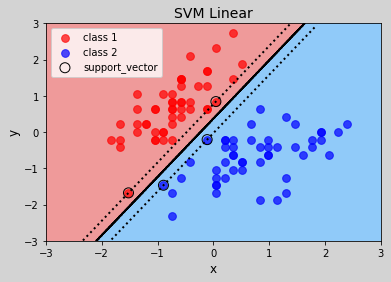

In [3]:
"""
*@File    ：svm.py
*@Des     ：TODO
*@Author  ：Mo
*@Date    ：2022/10/7 11:23
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm, datasets
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
x = iris.data
y = iris.target
X = x[y<2,:2] # 为便于绘图仅选择2个特征
y = y[y<2] # 为提供线性可分数据集，只选取了前两类鸢尾花数据集

# 数据预处理: 数据归一化
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
#引入模型 线性SVM：
model = svm.SVC(C=1e9, kernel='linear')
# 模型训练
model.fit(X, y)
# 测试样本（绘制分类区域）: 以样本的特征向量生成多维的网格采样点矩阵
axis=[-3,3,-3,3]
xlist1 = np.linspace(axis[0],axis[1],int((axis[1]-axis[0])*100))
xlist2 = np.linspace(axis[2],axis[3],int((axis[3]-axis[2])*100))
XGrid1, XGrid2 = np.meshgrid(xlist1, xlist2)
w = model.coef_[0]
b = model.intercept_[0]
plot_x = np.linspace(axis[0],axis[1],200)
up_y = -w[0]/w[1]*plot_x - b/w[1] + 1/w[1]
down_y = -w[0]/w[1]*plot_x - b/w[1] - 1/w[1]
up_index = (up_y>=axis[2]) & (up_y<=axis[3])
down_index = (down_y>=axis[2]) & (down_y<=axis[3])
# 预测并绘制结果
Z = model.predict(np.vstack([XGrid1.ravel(), XGrid2.ravel()]).T)
Z = Z.reshape(XGrid1.shape)
# 设置标题、横坐标、纵坐标
plt.figure('SVM Linear', facecolor='lightgray')
plt.title('SVM Linear', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.tick_params(labelsize=10)

# 绘制分类线
plt.plot(plot_x[up_index],up_y[up_index],c='black',linewidth=2,linestyle=':') # y=1, 正例分类线
plt.plot(plot_x[down_index],down_y[down_index],c='black',linewidth=2,linestyle=':') # y=-1, 负例分类线
# 绘制超平面
plt.contourf(XGrid1, XGrid2, Z, cmap=ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])) # 填充分类轮廓
plt.contour(XGrid1, XGrid2, Z, colors=('k',)) # 绘制轮廓线 超平面
# 绘制数据点
plt.scatter(X[y==0,0],X[y==0,1],s=60, marker='o', alpha=0.7, label='class 1', c='r') # 绘制类别1
plt.scatter(X[y==1,0],X[y==1,1],s=60, marker='o', alpha=0.7, label='class 2', c='b') # 绘制类别2
# 绘制支持向量
plt.scatter(model.support_vectors_[:,0],model.support_vectors_[:,1],s=100, c="none", edgecolor='k', marker="o",label="support_vector")
plt.legend()
plt.show()
